In [1]:
%load_ext autoreload
%autoreload 2

In [3]:

import pandas as pd
pd.set_option('max_colwidth', None)
import os

In [4]:
from utils_printable import printable



abbreviations = {"RAC1P": "RAC", "White alone": "White", "Reference person": "Ref person", \
"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions": "Empl. for-profit-c",\
"Employee of a private not-for-profit, tax-exempt, or charitable organization": "Empl. no-profit-c",
"Self-employed in own not incorporated business, professional practice, or farm": "Self-Empl. not incorp" ,     
"Self-employed in own incorporated business, professional practice or farm": "Self-Empl. incorp" ,
"Local government employee (city, county, etc.)" : "Local gov. Empl. ",
"Federal government employee": "Federal gov.  Empl.",
"California/CA":"CA", "Never married or under 15 years old": "Never married/<15yrs", 
"Biological son or daughter": "Son/daughter", "Regular high school diploma":"HS", \
"Asian alone":"Asian", "1 or more years of college credit":"1+ collage cr",
"Some Other Race alone": "Other", "Bachelor's degree": "Bachelor", "Master's degree": "Master", 
                "Some college, but less than 1 year": "<1y collage",
                "Associate's degree":"Associate",
"Noninstitutionalized group quarters population": "Noninstit. GQs", 
"OCCP=CMM-Software Developers": "OCCP=CMM-SW Dev", 
                 "Professional degree beyond a bachelor's degree": "Prof beyond bachelor"}

# Load data

In [5]:
from folktables import ACSDataSource, ACSIncome

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)

In [6]:
from folktables.acs import adult_filter
from folktables import BasicProblem
import numpy as np

feature_names = [ 'AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP',  'RELP', 'WKHP', 'SEX', 'RAC1P' ]

target='PINCP'

ACSIncome_outcome = BasicProblem(
    features=feature_names,
    target=target,
    group='RAC1P',
    preprocess=adult_filter,
)

In [7]:
features, label, group = ACSIncome_outcome.df_to_numpy(acs_data)

In [8]:
continuous_attributes = ['AGEP', 'WKHP']

In [9]:
categorical_attributes = list(set(feature_names)-set(continuous_attributes))

In [10]:
import pandas as pd


df = pd.DataFrame(features, columns=feature_names)
df["income"] = label
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,income
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,48500.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,7700.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,17200.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,12000.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,300.0


# Remap columns

From label encoding to interpretable notation: e.g., 0, 1 to "male", "female"

In [11]:
filename = os.path.join(os.path.curdir, "datasets", "ACSPUMS", "PUMS_Data_Dictionary_2018.csv")
df_mappings = pd.read_csv(filename)

In [12]:
remapping_cols = {}

orig_col = "1"
new_col = "Record Type"
cols_i = [orig_col, new_col]

#col_name = "OCCP"
for col_name in categorical_attributes:
    dict_i = df_mappings.loc["VAL"].loc[col_name][cols_i].set_index(orig_col).to_dict()[new_col]
    dict_i = {float(k) if (k not in ["b", "bb", 'bbb', 'bbbb']) else -1 :v for k,v in dict_i.items()}
    remapping_cols[col_name] = dict_i

In [13]:
from copy import deepcopy

df_analysis = deepcopy(df)

for column_name in remapping_cols:
    df_analysis[column_name] = df[column_name].replace(remapping_cols[column_name])

We substituite nan with string "NaN"

In [14]:
for c in df_analysis:
    if df_analysis[c].isna().any():
        print(c)
        df_analysis[c].fillna('NaN', inplace=True)

In [15]:
df_analysis.to_csv(os.path.join(os.path.curdir, "datasets", "ACSPUMS", "adult_dataset_income.csv"), index=False)

In [16]:
continuous_attributes = ['AGEP', 'WKHP']

In [17]:
df_analysis.shape

(195665, 11)

# Taxonomy

In [18]:
df_analysis_proc = deepcopy(df_analysis)

### Occupation

In [19]:
attr = "OCCP"

generalization_dict_tax = {}
generalization_dict_tax[attr] = {x: x.split("-")[0] for x in df_analysis_proc[attr].values if "-" in x}

### Country

We rename some of the columns for vizualization and mapping reasons.

In [20]:
if "POBP" in df_analysis_proc.columns:
    df_analysis_proc["POBP"] = df_analysis_proc["POBP"]\
    .replace({"England":"United Kingdom", 'Scotland': "United Kingdom", \
              "United Kingdom, Not Specified": "United Kingdom",  'Northern Ireland': "United Kingdom",\
               "USSR": "Russia", "Hong Kong": "Hong Kong SAR",
             "Democratic Republic of Congo (Zaire)": 'Democratic Republic of the Congo',
             "Trinidad & Tobago": "Trinidad and Tobago", 'Macedonia':'North Macedonia',
             'Antigua & Barbuda': 'Antigua and Barbuda', \
              'Commonwealth of the Northern Mariana Islands':'Northern Mariana Islands',
             'St. Vincent & the Grenadines': 'St. Vincent and the Grenadines', \
              #simplification
             "Azores Islands": "Portugal"})

In [21]:
# https://statisticstimes.com/geography/countries-by-continents.php
df_taxonomy_country = pd.read_csv("country_hierarchies.csv", header=None, index_col=0)

df_taxonomy_country.columns=["Country or Area","ISO-alpha3 Code", "M49 Code", "Region 1", "Region 2", "Continent"]

df_taxonomy_country["Country or Area"] = df_taxonomy_country["Country or Area"].replace({
    "Viet Nam":"Vietnam", "Bolivia (Plurinational State of)": "Bolivia" ,\
      "Russian Federation": "Russia",'Iran (Islamic Republic of)': 'Iran', \
    "Lao People's Democratic Republic": "Laos", 'Syrian Arab Republic': "Syria", 
    'Venezuela (Bolivarian Republic of)': "Venezuela",
    "Republic of Moldova": "Moldova", "Czechia": "Czech Republic",
        'United Republic of Tanzania': "Tanzania", 'Côte d’Ivoire': "Ivory Coast",
        'United States Virgin Islands': 'US Virgin Islands', 'Saint Lucia': 'St. Lucia', 
    'Saint Kitts and Nevis': 'St. Kitts-Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    "United Kingdom of Great Britain and Northern Ireland" : "United Kingdom",\
    "China, Hong Kong Special Administrative Region" : "Hong Kong SAR"
})


g_hierarchy = {}
target_cols = ["Country or Area", "Region 1", "Continent"]
for i, row in df_taxonomy_country.iterrows():
    levels = [col for col in target_cols if pd.notnull(row[col])]
    
    for l in range(len(levels)-1):
        tax_c, tax_p = row[levels[l]], row[levels[l+1]]
        # If already exist but the value is different
        if "Korea" in tax_c:
            tax_c = "Korea"
        
        if tax_c in g_hierarchy and tax_p!=g_hierarchy[tax_c]:
            print(row)
            raise ValueError()
        if tax_c == tax_p:
            continue
        g_hierarchy[tax_c] = tax_p
attr = 'POBP'
#g_hierarchy = {}
g_hierarchy.update({"North America": "America", 
 "South America": "America", 
 "Americas, Not Specified" : "America", 
"Other Europe, Not Specified": "Europe",
"Eastern Africa, Not Specified": "Africa",
"Other Asia, Not Specified": "Asia",
"South Central Asia, Not Specified": "Asia",
"Caribbean, Not Specified": "North America",
"Other US Island Areas, Oceania, Not Specified, or at Sea": "Oceania",
"Other Africa, Not Specified": "Africa",
"Western Africa, Not Specified": "Africa",
                   "Taiwan" : 'Eastern Asia',
                   'Czechoslovakia':'Eastern Europe', 'Yugoslavia':'Southern Europe'})


In [22]:
generalization_dict_tax_u = deepcopy(g_hierarchy)
delete_values = []
for c, v in df_analysis_proc["POBP"].value_counts().items():
    if c not in g_hierarchy.keys():
        if "/" in c:
            g_hierarchy[c] = "United States of America"
        else:
            delete_values.append(c)

delete_values.append("North America")
delete_values.append("South America")
delete_values.append("Micronesia")

tot_deleted = 0
for c in delete_values:
    print(c, len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c]))
    tot_deleted +=len(df_analysis_proc.loc[df_analysis_proc["POBP"]==c])
print(tot_deleted, round(tot_deleted/len(df_analysis_proc),5))

Asia 54
Europe 23
Africa 18
West Indies 2
North America 0
South America 4
Micronesia 8
109 0.00056


Delete rows for which the detailed information is not available

In [23]:
df_analysis_proc = df_analysis_proc.loc[df_analysis_proc["POBP"].isin(delete_values)==False]

In [24]:
generalization_dict_tax[attr] = generalization_dict_tax_u

# Tree divergence - income - individual

## Tree

In [25]:
metric = "d_outcome"
target = "income"

In [26]:
type_criterion="divergence_criterion"
type_experiment = "one_at_time"
min_sup_divergence = 0.025

In [27]:
min_support_trees = [0.0025, 0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

In [28]:
tree_gen_name = "hierarchies gen"

In [57]:
from tree_discretization_ranking import TreeDiscretization_ranking
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence

import time
max_divergence_dict = {}
time_results = {}

for min_support_tree in min_support_trees:

    out = {}
    time_results[min_support_tree] = {}
    print(min_support_tree, end = " ")
    
    tree_discr = TreeDiscretization_ranking()


    
    start_time_tree = time.time()
    
    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analysis_proc,
        type_splitting=type_experiment,
        min_support=min_support_tree,
        metric=metric,
        continuous_attributes= list(continuous_attributes),
        storeTree=True,
        type_criterion = type_criterion,
        minimal_gain = 0.0,
        target_col = target
    )

    time_results[min_support_tree][tree_gen_name] = time.time() - start_time_tree
    
    generalization_dict_all = deepcopy(generalization_dict)
    generalization_dict_all.update(generalization_dict_tax)
    
    from utils_extract_divergence_generalized_ranking import (
        extract_divergence_generalized,
    )

    for apply_generalization in [False, True]:
        if apply_generalization == True:
            type_gen = "generalized"
        else:
            type_gen = "base"

        start_time_divergence = time.time()
        FP_fm = extract_divergence_generalized(
            df_analysis_proc,
            discretizations,
            generalization_dict_all,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            target_name = target,
            FPM_type="fpgrowth",
            metrics_divergence = ["d_outcome"],
            type_experiment = type_experiment,
            allow_overalp = False if type_experiment!="all_attributes" else True
        )
        time_results[min_support_tree][type_gen] = time.time() - start_time_divergence

        out[type_gen] = max(FP_fm[metric])
    max_divergence_dict[min_support_tree] = out

0.1 

In [37]:
max_divergence_dict[min_support_tree]

{'base': 105256.74307427197, 'generalized': 115751.94926969381}

# Plot

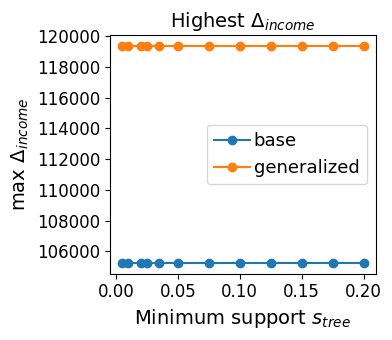

In [38]:
show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]



from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt



metric_name = "Δ_fpr"


vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support_tree: max_divergence_dict[min_support_tree]["base"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}
gen =  { min_support_tree: max_divergence_dict[min_support_tree]["generalized"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))
ax.set_title(r"Highest Δ$_{income}$")


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")

ax.set_ylabel(r"max Δ$_{income}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
plt.legend( fontsize = 13, handletextpad=0.2)



plt.tight_layout();
plt.savefig(f"{outfig_dir}/adult_sensitivity_s_{min_sup_divergence}.pdf");

## Time

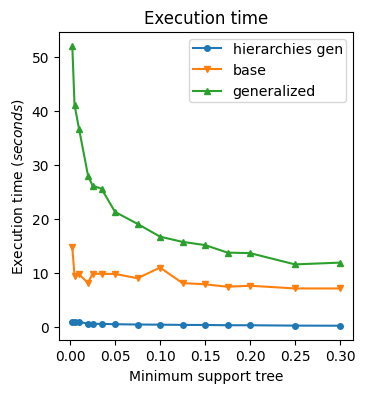

In [41]:
import os
from utils_plot import plotDicts

info_plot = {}

for min_support_tree, res in time_results.items():
    for exp, value in res.items():
        if exp not in info_plot:
            info_plot[exp] = {}
        info_plot[exp][min_support_tree] = value
        
figure_name = os.path.join(outfig_dir, f"adult_stree_{min_sup_divergence}_{metric}_time_trees.pdf")

size_fig = (3.8,4)
fig = plotDicts(info_plot, marker=True, \
           sizeFig=size_fig, title="Execution time", #yscale="log", 
          xlabel="Minimum support tree",  ylabel="Execution time $(seconds)$", labelSize=10.2,
          outside=False,  saveFig=False, nameFig = figure_name)

In [42]:
pd.DataFrame(info_plot)

,hierarchies gen,base,generalized
0.0025,0.852317,14.713142,52.104668
0.0050,0.949103,9.475591,41.124615
0.0100,0.888622,9.700263,36.695021
0.0200,0.569042,8.126633,28.002201
0.0250,0.537323,9.838440,26.161108
0.0350,0.520767,9.795527,25.577757
0.0500,0.467581,9.795904,21.290165
0.0750,0.405349,8.985714,19.067542
0.1000,0.380931,10.964560,16.698303
0.1250,0.335885,8.090428,15.731932


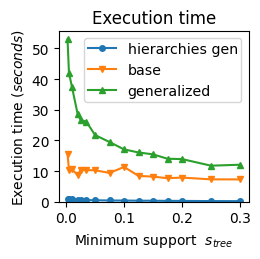

In [55]:
size_fig = (2.7,2.7)

import os
from utils_plot import plotDicts

info_plot = {}

for min_support_tree, res in time_results.items():
    for exp, value in res.items():
        if exp not in info_plot:
            info_plot[exp] = {}
        info_plot[exp][min_support_tree] = value
        
for exp in ["base", "generalized"]:
    for min_support_tree in info_plot[exp]:
        info_plot[exp][min_support_tree] = info_plot[exp][min_support_tree] + info_plot[tree_gen_name][min_support_tree]
        
figure_name = os.path.join(outfig_dir, f"adult_stree_{min_sup_divergence}_{metric}_time_sensitivity_trees.pdf")


fig = plotDicts(info_plot, marker=True, \
           sizeFig=size_fig, title="Execution time", #yscale="log", 
         xlabel=r"Minimum support  $s_{tree}$",  ylabel="Execution time $(seconds)$", labelSize=10.2,
          outside=False,  saveFig=True, nameFig = figure_name, limit = (0, None))

In [59]:
len(df_analysis)*0.0025

489.1625

In [44]:
pd.DataFrame(info_plot)

,hierarchies gen,base,generalized
0.0025,0.852317,15.565459,52.956985
0.0050,0.949103,10.424694,42.073718
0.0100,0.888622,10.588885,37.583643
0.0200,0.569042,8.695675,28.571243
0.0250,0.537323,10.375763,26.698430
0.0350,0.520767,10.316293,26.098524
0.0500,0.467581,10.263484,21.757746
0.0750,0.405349,9.391064,19.472892
0.1000,0.380931,11.345490,17.079234
0.1250,0.335885,8.426313,16.067818


In [56]:
generalization_dict

{'AGEP': {'[35.0-51.0]': '>=35.0', '>=52.0': '>=35.0'}}